In [1]:
import os
import json
import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from collections import defaultdict

In [20]:
def extract_log(dataset, model, task_id):
    target_dir = os.path.join("log", dataset)
    file_names = os.listdir(target_dir)
    case_dict = defaultdict(dict)
    for fname in file_names:
        try:
            fname_decomp = fname.split('-')
            ftask_id = fname_decomp[0]
            fmodel, ftype = fname_decomp[-1].split('.')
            select_flag = (ftask_id == task_id) and (fmodel == model)
        except:
            print("file {} skiped".format(fname))
            continue
        if not select_flag:
#             print("file {} skiped".format(fname))
            continue
        data_key = dataset + ftask_id + fmodel +''.join(fname_decomp[1:-1])
        if ftype == "meta":
            with open(os.path.join(target_dir, fname), mode='rt') as f:
                case_dict[data_key]['meta'] = json.load(f)
        if ftype == "log":
            df = pd.read_csv(os.path.join(target_dir, fname))
            df.columns = [c.strip() for c in df.columns]
            case_dict[data_key]['log'] = df
    return case_dict

In [29]:
def plot_along_epoch(case_dict, 
                     col_of_interests=["val_acc", "test_acc"], 
                     key_var='v',
                     key_var_name='v', 
                     key_var_filter=lambda x: True, 
                     case_meta_filter=lambda x: True, 
                     ax=plt):
    plot_order = []
    selected_case_keys = sorted([k for k in case_dict.keys() 
                                 if case_meta_filter(case_dict[k]['meta']) and key_var_filter(case_dict[k]['meta'][key_var])],
                               key=lambda x: case_dict[x]['meta'][key_var])
    for k in selected_case_keys:
        case = case_dict[k]
        cols = case['log'][col_of_interests]
        if len(cols) < 20:
            continue
        for c in col_of_interests:
            x = np.arange(len(cols[c]))
            ax.plot(x, cols[c], label="{} = {}".format(key_var_name, case['meta'][key_var]))
    ax.legend()

In [4]:
def get_stats_df(case_dict):
    df = None
    for k, case in case_dict.items():
        record_dict = {"key": k}
        record_dict.update(case['meta'])
        if df is None:
            df = pd.DataFrame(columns=list(record_dict.keys()))
        df = df.append(record_dict, ignore_index=True)
    return df

# CIFAR 10

In [22]:
case_dict_cifar10 = extract_log("CIFAR10", "ResNet18", "try")

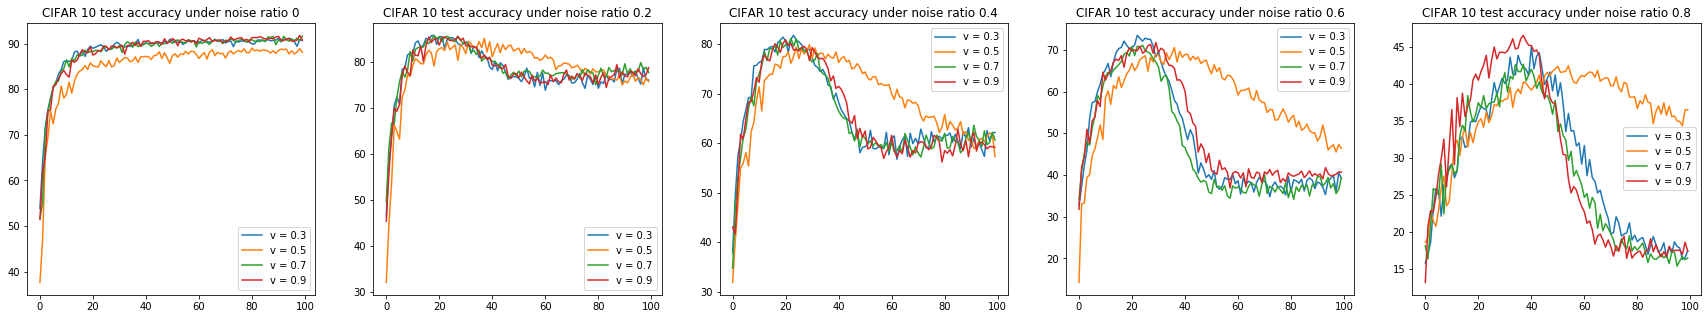

In [24]:
## investigate cases by label noise
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
for i, nr in enumerate([0, 0.2, 0.4, 0.6, 0.8]):
    plot_along_epoch(case_dict_cifar10, col_of_interests=['test_acc'], case_meta_filter=lambda x: x['noise_ratio'] == nr, ax=ax[i])
    ax[i].set_title('CIFAR 10 test accuracy under noise ratio {}'.format(nr))

In [25]:
case_dict_imdb = extract_log("IMDB", "LSTM", "final")

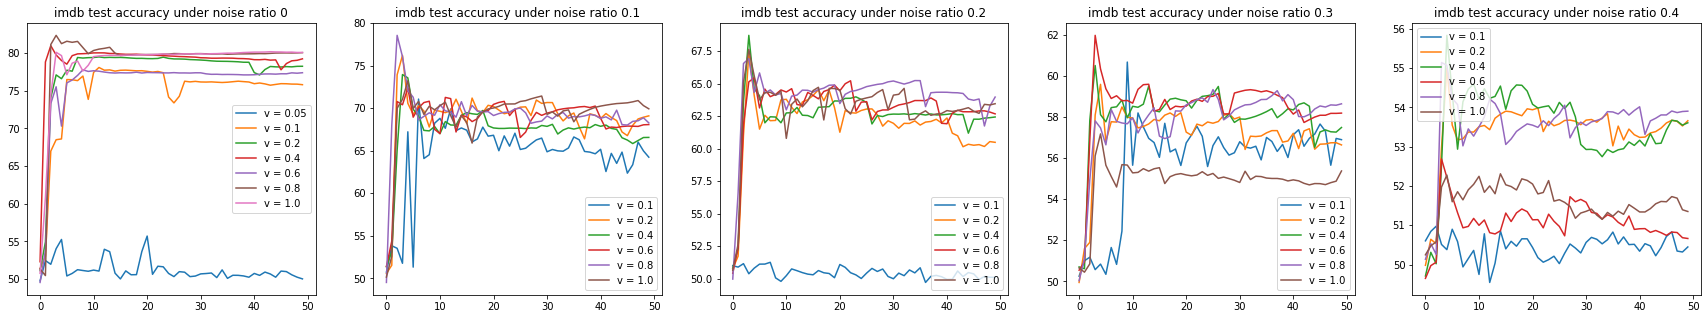

In [27]:
## investigate cases by label noise
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
for i, nr in enumerate([0, 0.1, 0.2, 0.3, 0.4]):
    plot_along_epoch(case_dict_imdb, col_of_interests=['test_acc'], case_meta_filter=lambda x: x['noise_ratio'] == nr, ax=ax[i])
    ax[i].set_title('imdb test accuracy under noise ratio {}'.format(nr))

# MNIST

In [5]:
case_dict_mnist = extract_log("MNIST", "DNN", "more_about_v_alpha")

In [6]:
sdf_mnist = get_stats_df(case_dict_mnist)
sdf_mnist

,key,dataset,model,task_id,cuda,eps,lr,v,batch_size,num_epochs,noise_ratio,alpha,auto
0,MNISTmore_about_v_alphaDNN191230222630710,MNIST,DNN,more_about_v_alpha,1,1.9,0.0001,0.5,128,100,0.0,0.1,True
1,MNISTmore_about_v_alphaDNN191230222637619,MNIST,DNN,more_about_v_alpha,2,1.9,0.0001,1.0,128,100,0.0,0.1,True
2,MNISTmore_about_v_alphaDNN191230222643651,MNIST,DNN,more_about_v_alpha,3,1.9,0.0001,2.0,128,100,0.0,0.1,True
3,MNISTmore_about_v_alphaDNN1912302226491468,MNIST,DNN,more_about_v_alpha,4,1.9,0.0001,4.0,128,100,0.0,0.1,True
4,MNISTmore_about_v_alphaDNN1912302226543212,MNIST,DNN,more_about_v_alpha,5,1.9,0.0001,8.0,128,100,0.0,0.1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,MNISTmore_about_v_alphaDNN191231035723392,MNIST,DNN,more_about_v_alpha,5,1.9,0.0001,8.0,128,100,0.8,1.5,True
96,MNISTmore_about_v_alphaDNN1912310357233523,MNIST,DNN,more_about_v_alpha,4,1.9,0.0001,4.0,128,100,0.8,1.5,True
97,MNISTmore_about_v_alphaDNN1912310400418263,MNIST,DNN,more_about_v_alpha,3,1.9,0.0001,2.0,128,100,0.8,1.5,True
98,MNISTmore_about_v_alphaDNN1912310403024027,MNIST,DNN,more_about_v_alpha,2,1.9,0.0001,1.0,128,100,0.8,1.5,True


In [7]:
list(sdf_mnist['alpha'].unique())

[0.1, 0.3, 1.0, 1.5]

C:\Users\wangz\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


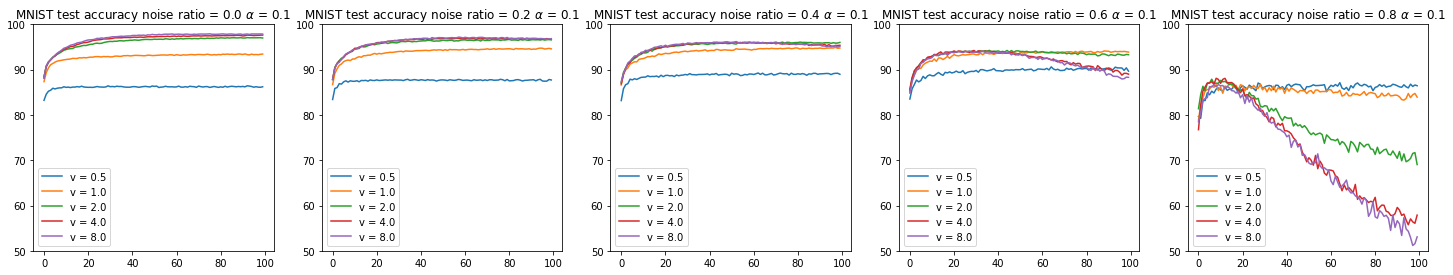

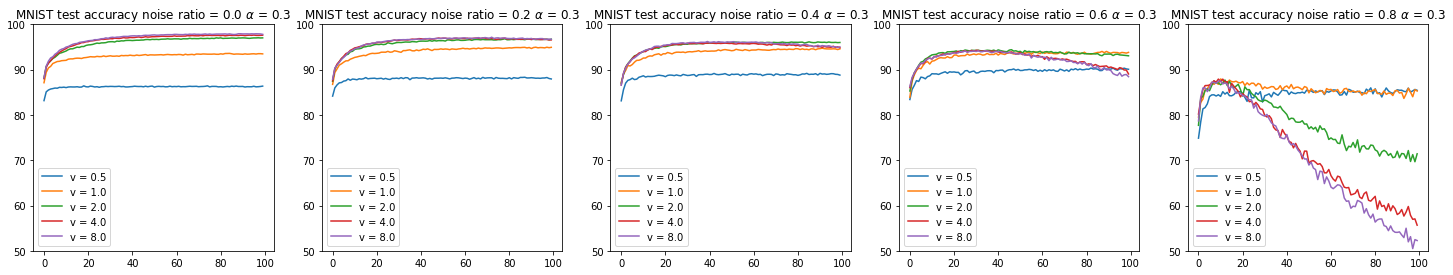

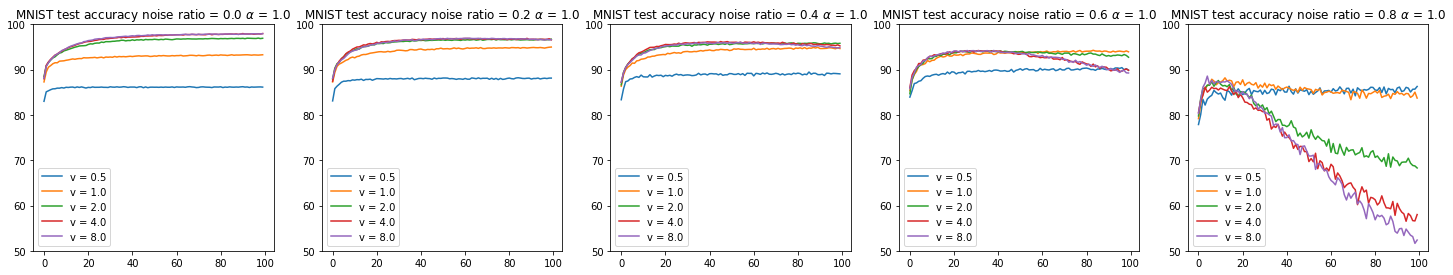

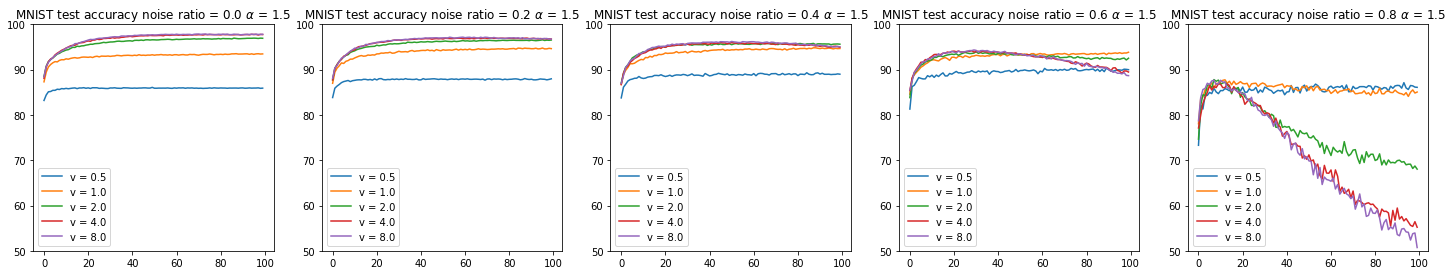

In [8]:
## investigate cases by label noise
nr_list = list(sdf_mnist['noise_ratio'].unique())
alpha_list = list(sdf_mnist['alpha'].unique())
for alpha in alpha_list:
    fig, ax = plt.subplots(1, len(nr_list), figsize=(30/1.2, 5/1.2))
    for i, nr in enumerate(nr_list):
        plot_along_epoch(case_dict_mnist, col_of_interests=['test_acc'], case_meta_filter=lambda x: (x['noise_ratio'] == nr and x['alpha'] == alpha), ax=ax[i])
        ax[i].set_title(r'MNIST test accuracy noise ratio = {} $\alpha$ = {}'.format(nr, alpha))
        ax[i].set_ylim([50, 100])
    fig.show()

C:\Users\wangz\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


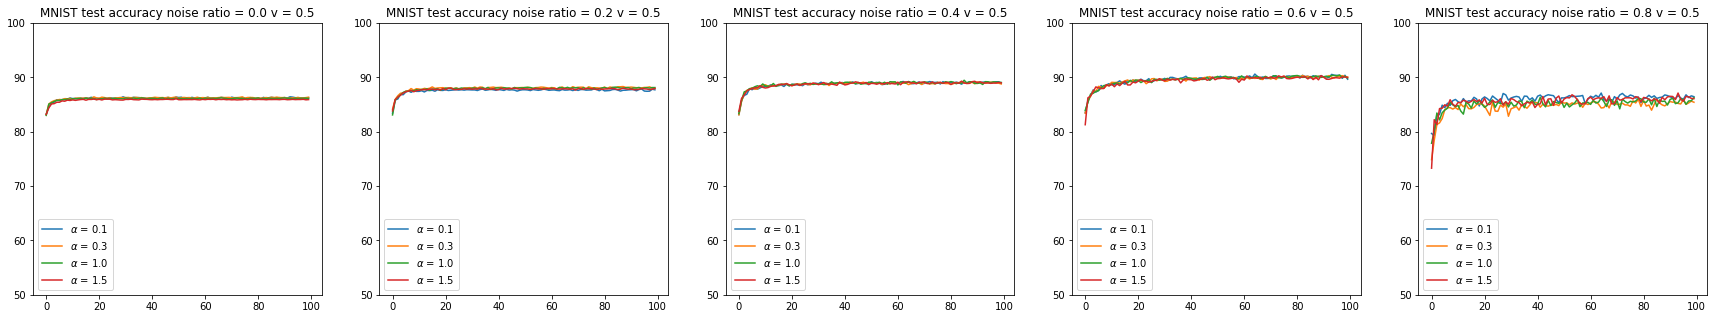

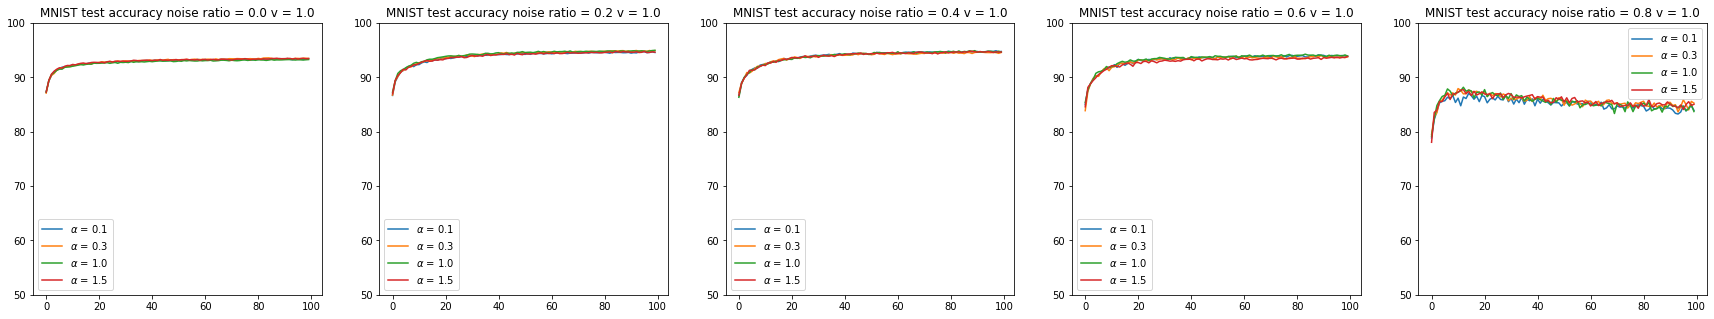

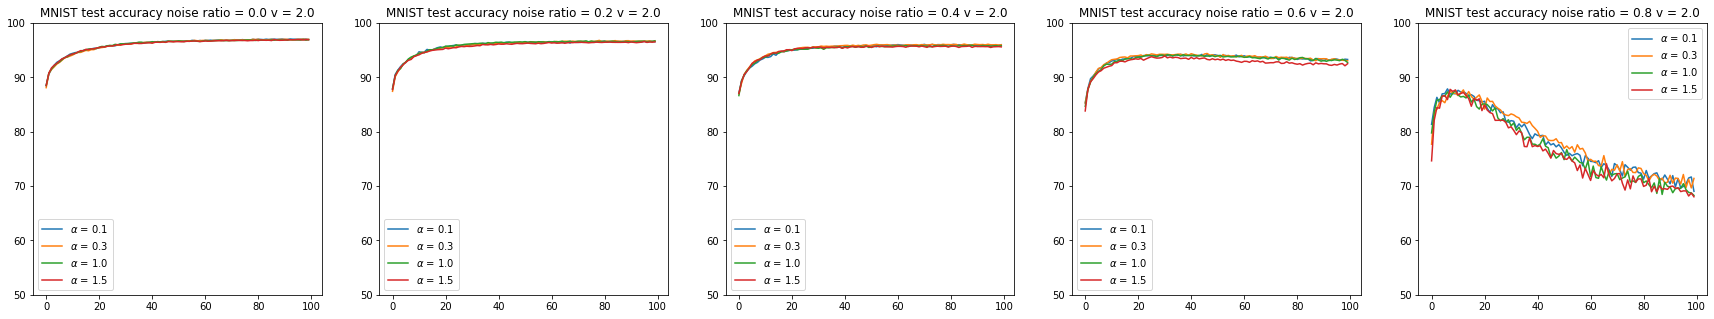

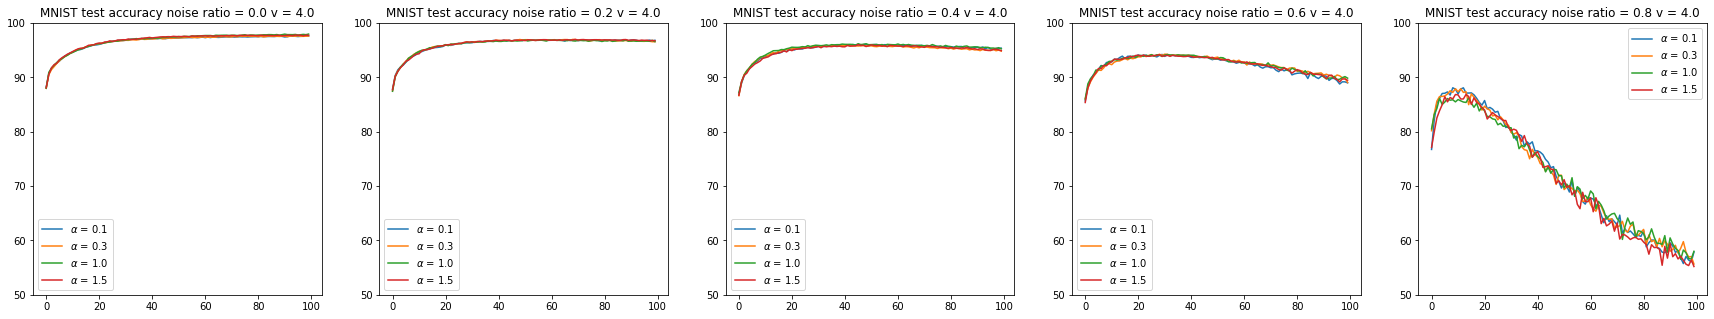

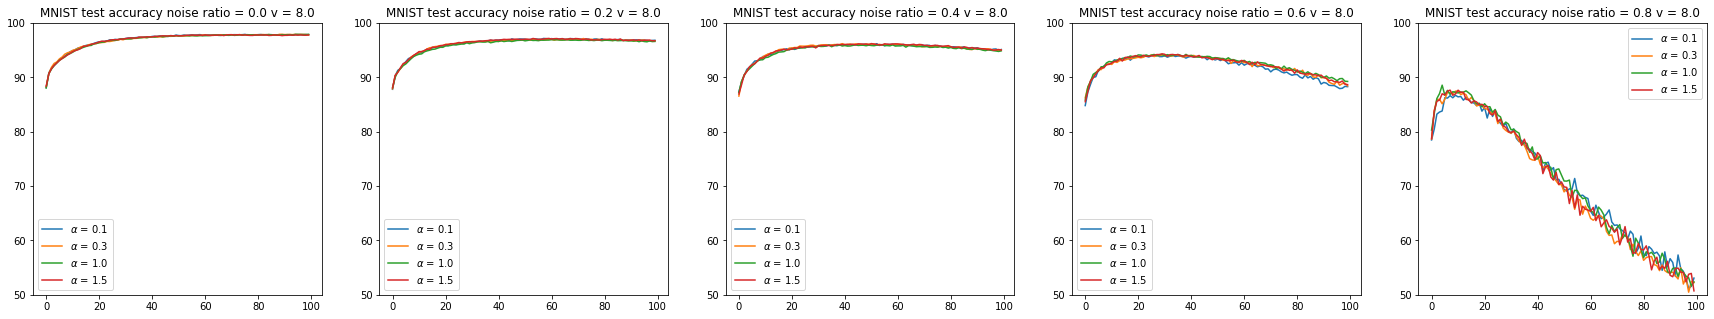

In [10]:
nr_list = list(sdf_mnist['noise_ratio'].unique())
v_list = list(sdf_mnist['v'].unique())
for v in v_list:
    fig, ax = plt.subplots(1, len(nr_list), figsize=(30, 5))
    for i, nr in enumerate(nr_list):
        plot_along_epoch(case_dict_mnist, col_of_interests=['test_acc'], key_var='alpha', key_var_name=r'$\alpha$', case_meta_filter=lambda x: (x['noise_ratio'] == nr and x['v'] == v), ax=ax[i])
        ax[i].set_title('MNIST test accuracy noise ratio = {} v = {}'.format(nr, v))
        ax[i].set_ylim([50, 100])
    fig.show()

In [11]:
case_dict_mnist2 = extract_log("MNIST", "DNN", "negative_alpha")
sdf_mnist2 = get_stats_df(case_dict_mnist2)

C:\Users\wangz\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


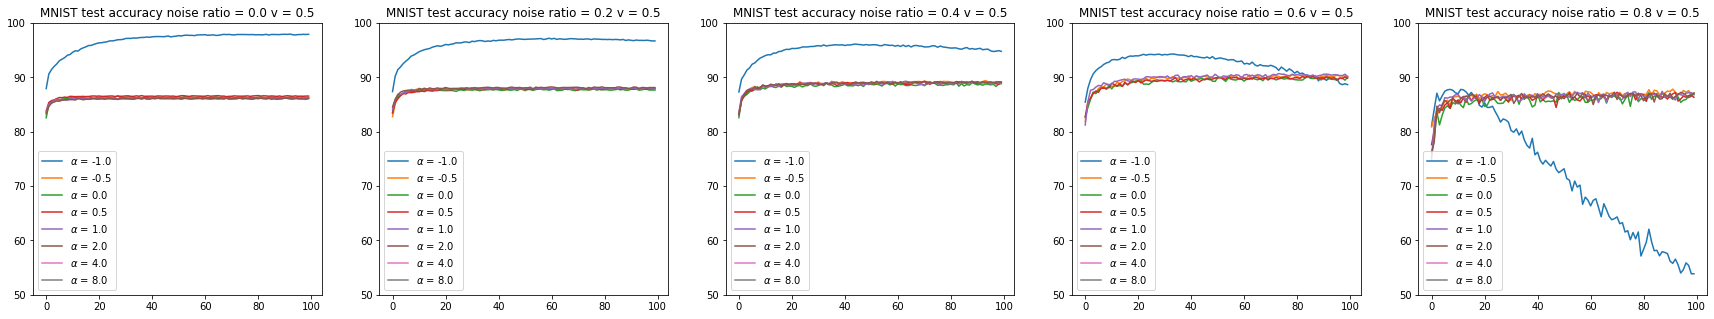

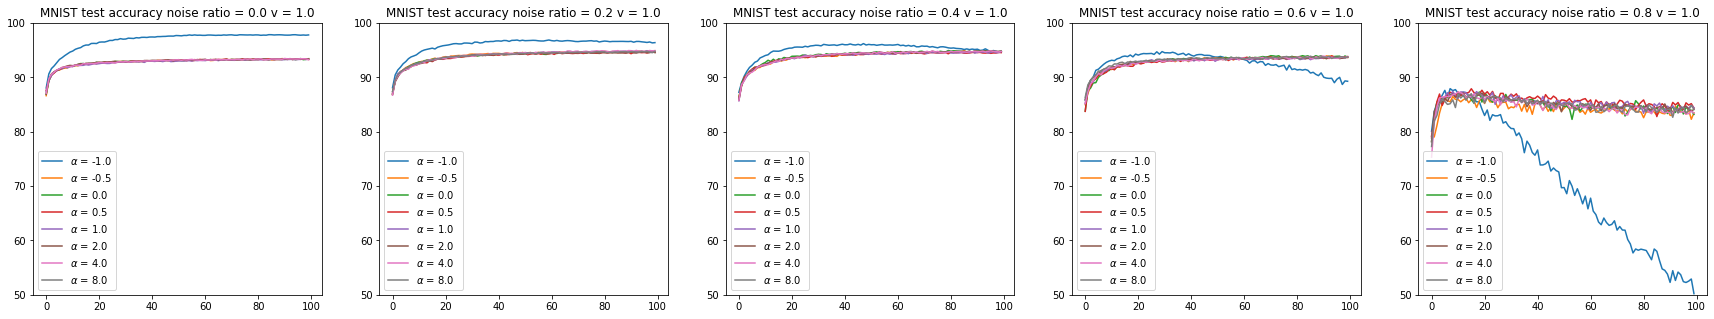

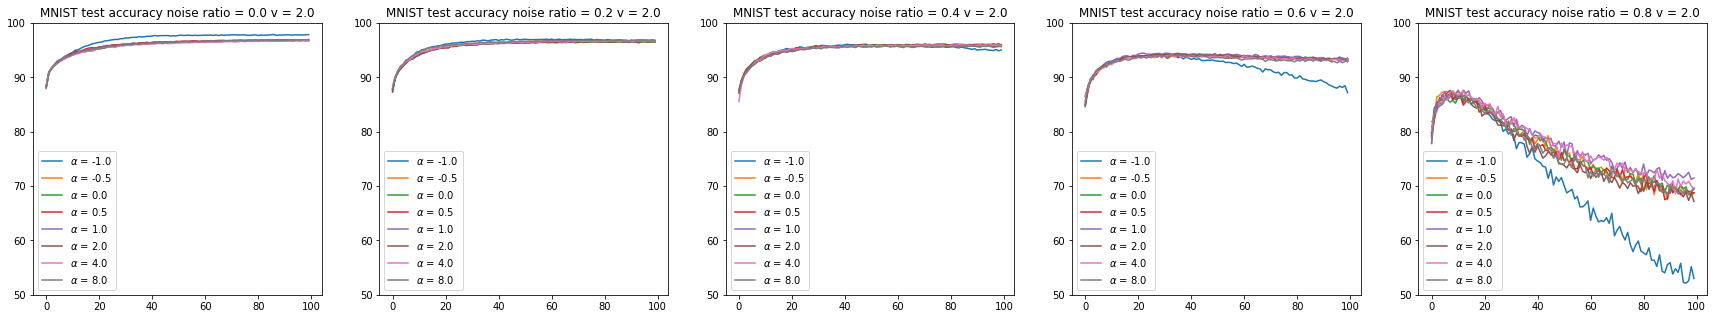

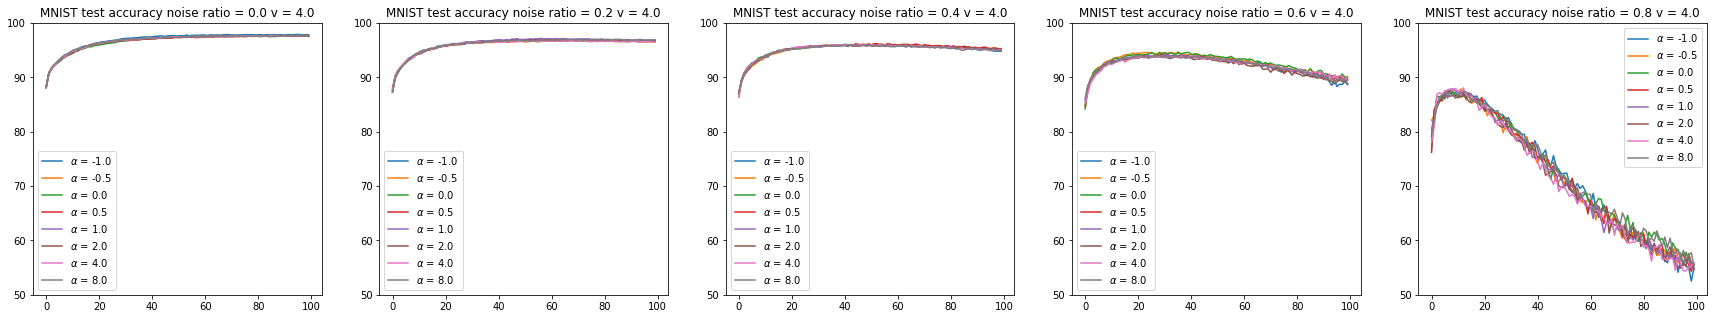

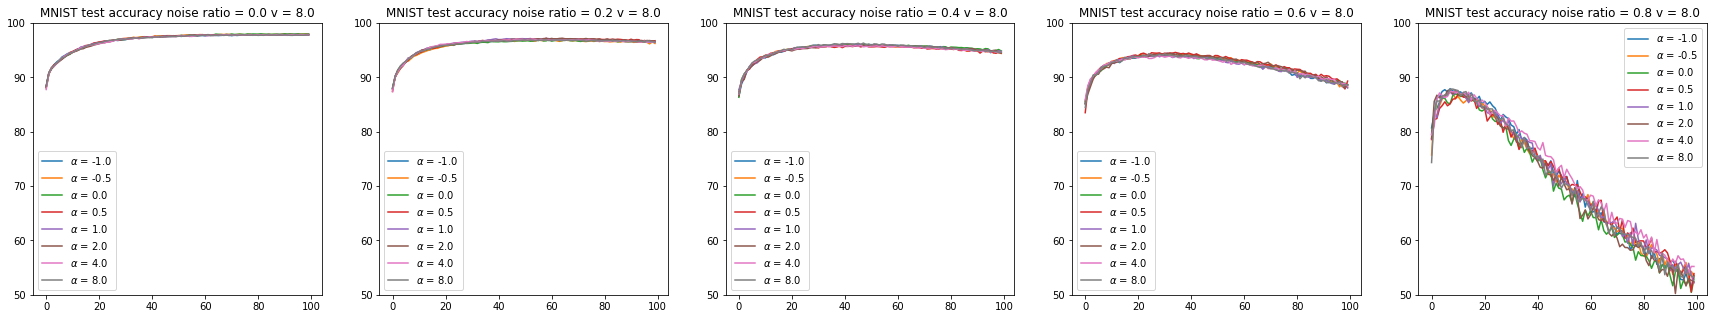

In [12]:
nr_list = list(sdf_mnist2['noise_ratio'].unique())
v_list = list(sdf_mnist2['v'].unique())
for v in v_list:
    fig, ax = plt.subplots(1, len(nr_list), figsize=(30, 5))
    for i, nr in enumerate(nr_list):
        plot_along_epoch(case_dict_mnist2,
                         col_of_interests=['test_acc'], 
                         key_var='alpha',
                         key_var_name=r'$\alpha$',
                         key_var_filter=lambda x: x>=-1 and x<=8,
                         case_meta_filter=lambda x: (x['noise_ratio'] == nr and x['v'] == v), ax=ax[i])
        ax[i].set_title('MNIST test accuracy noise ratio = {} v = {}'.format(nr, v))
        ax[i].set_ylim([50, 100])
    fig.show()

[-8.0, -4.0, -2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 4.0, 8.0]


C:\Users\wangz\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


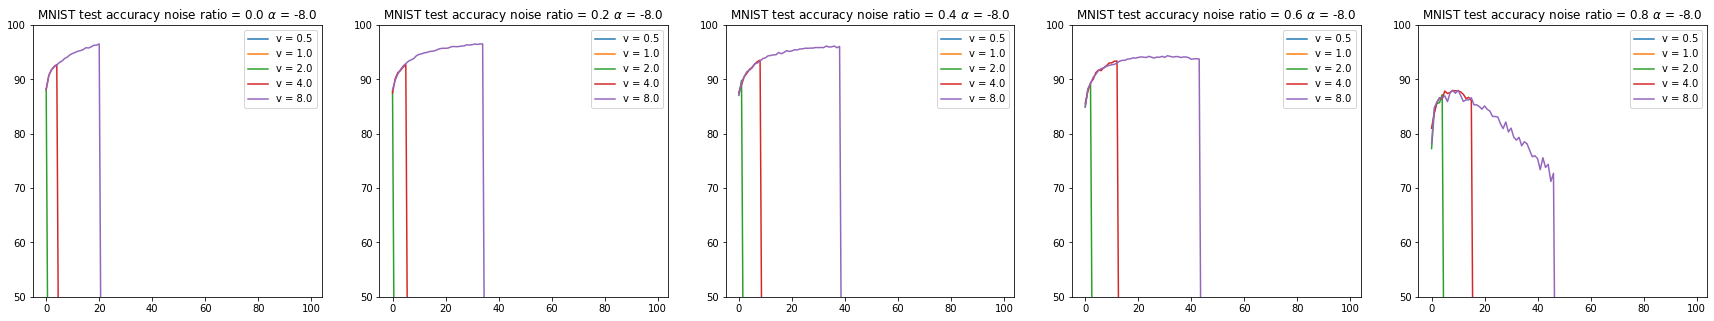

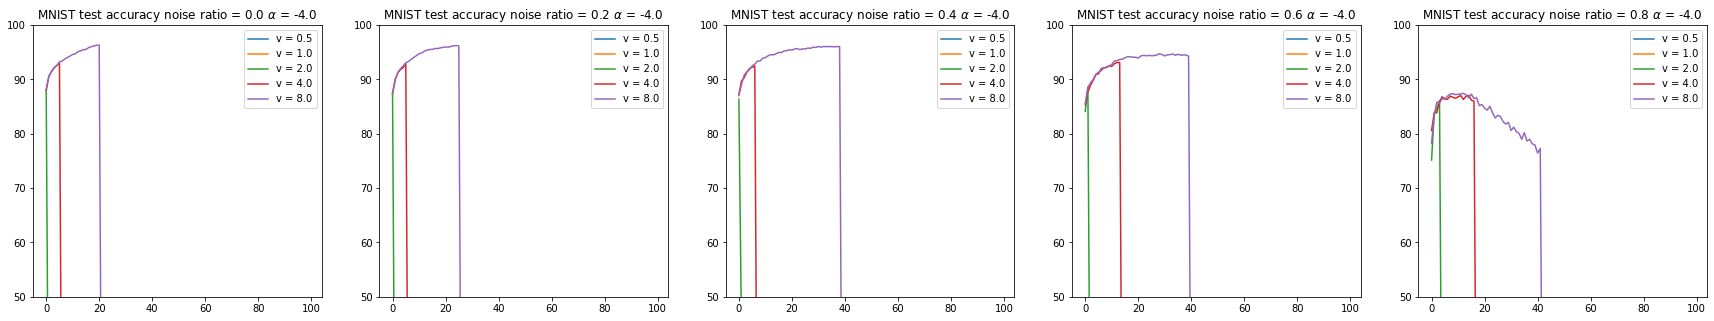

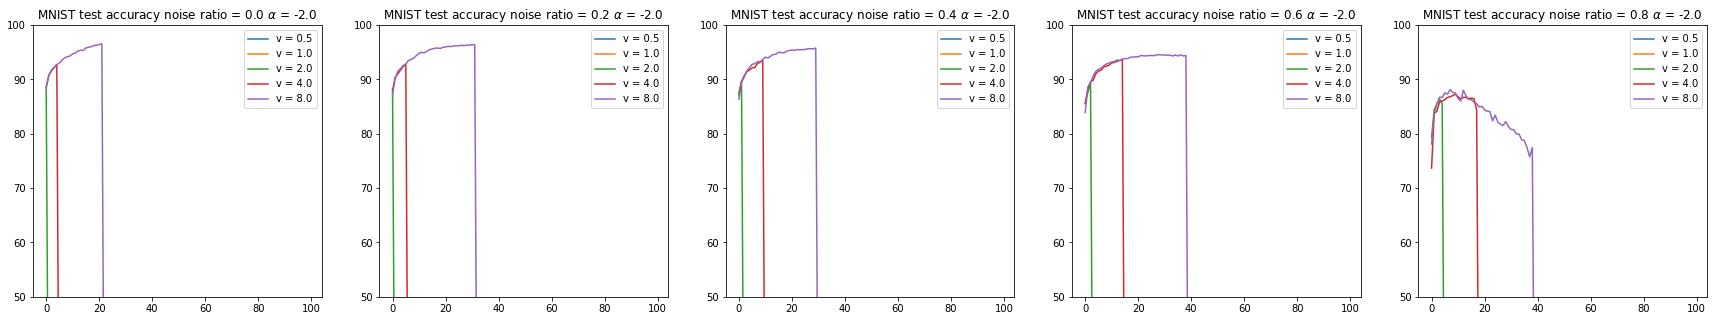

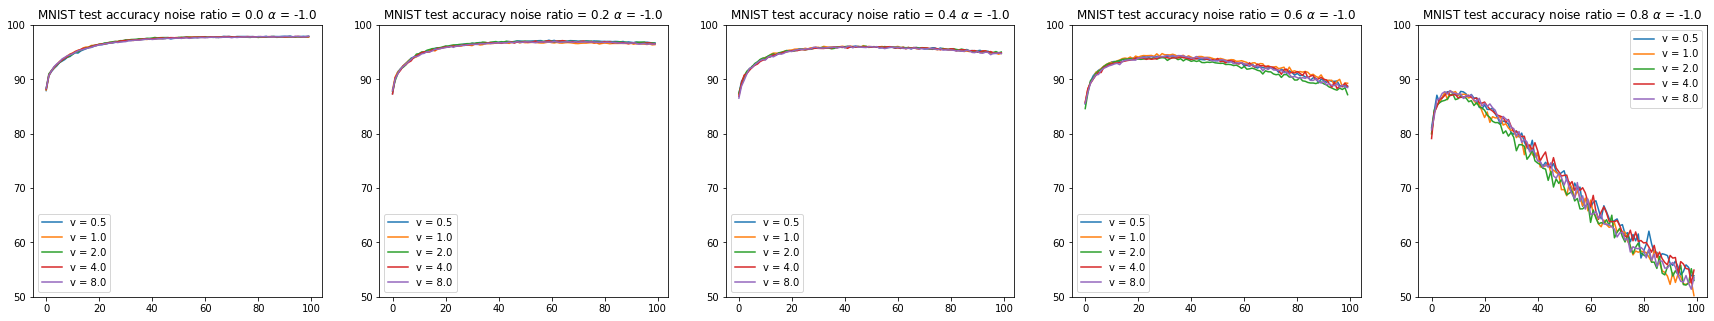

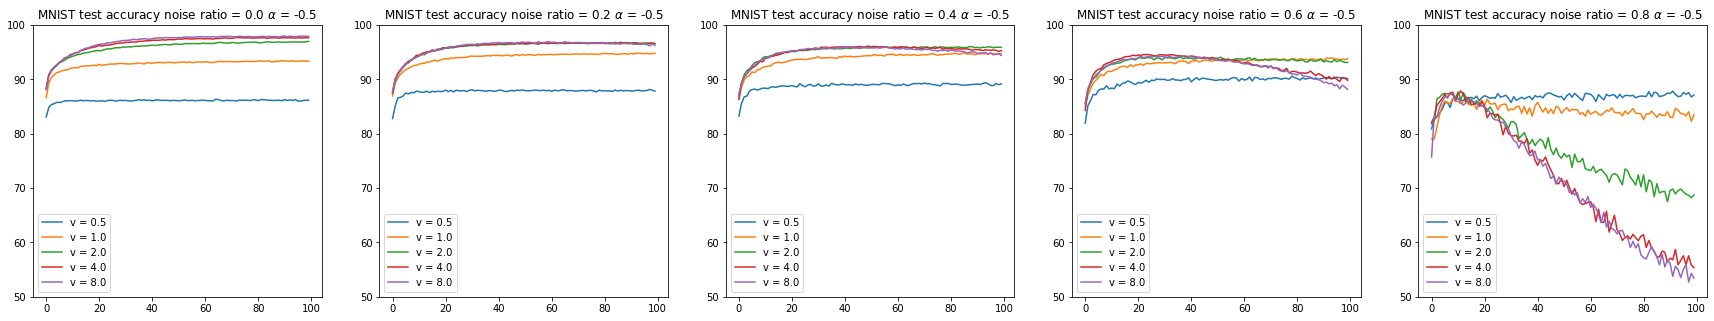

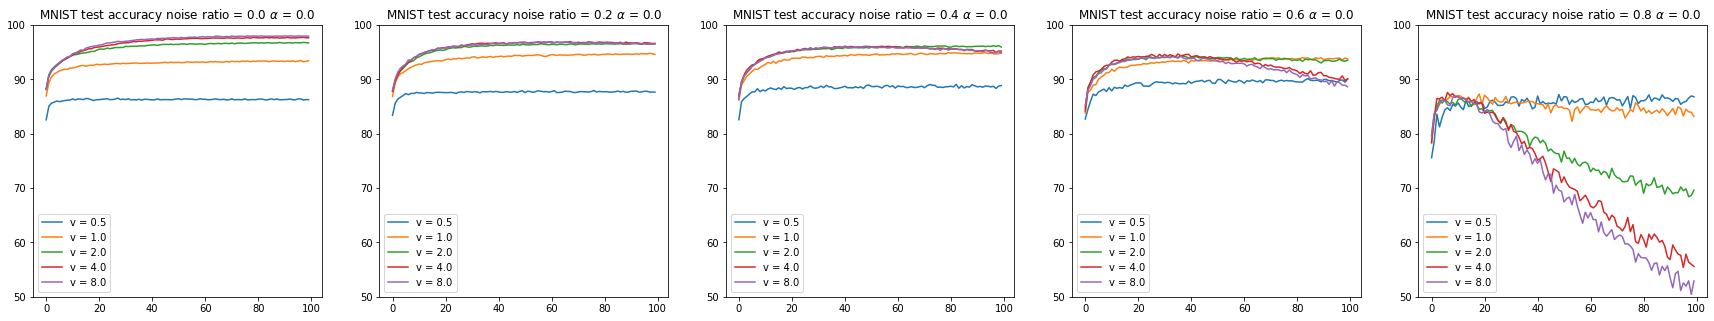

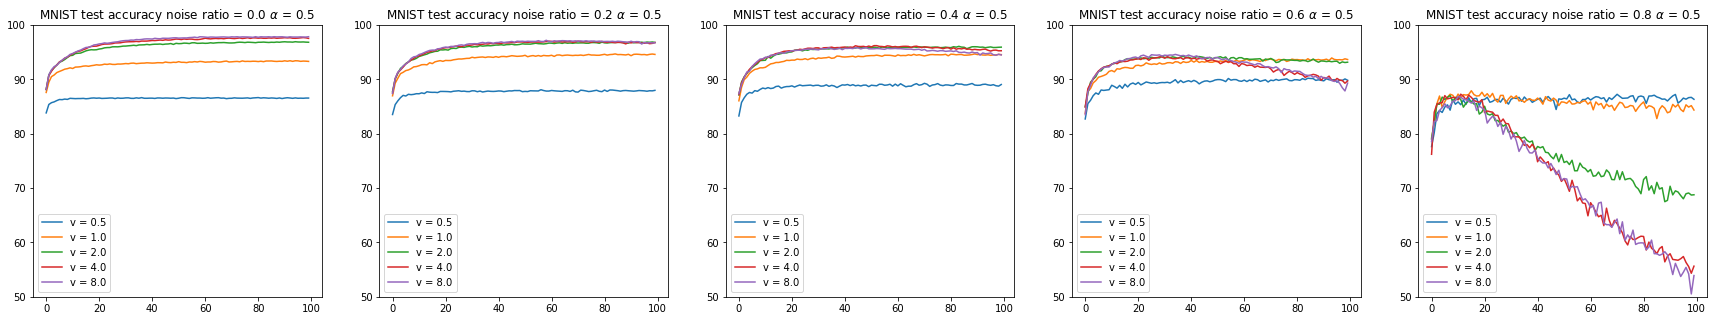

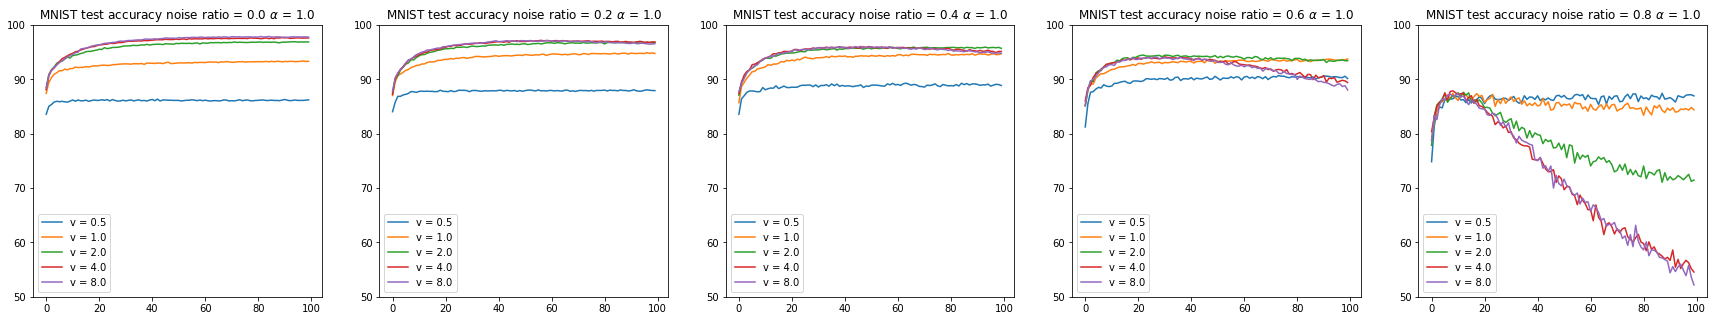

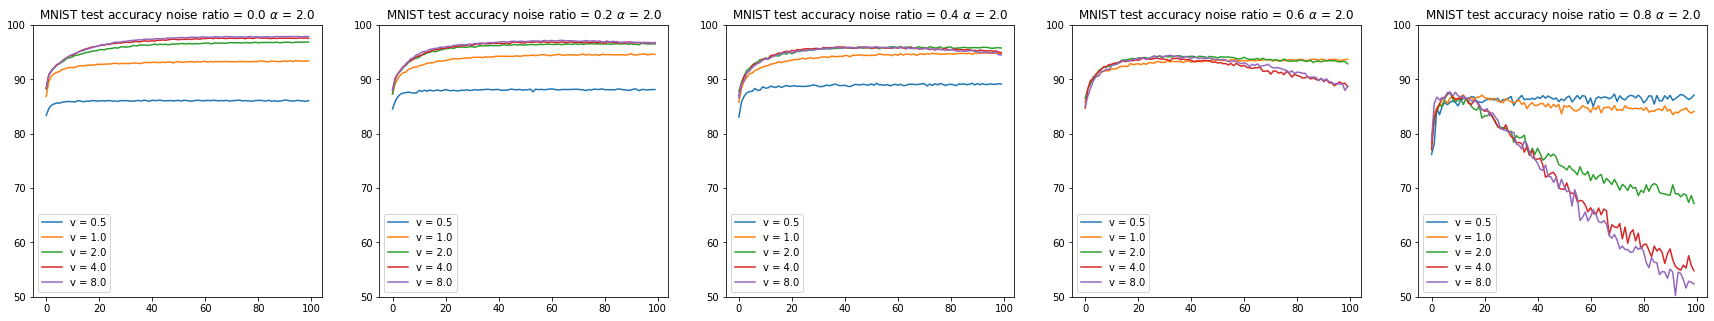

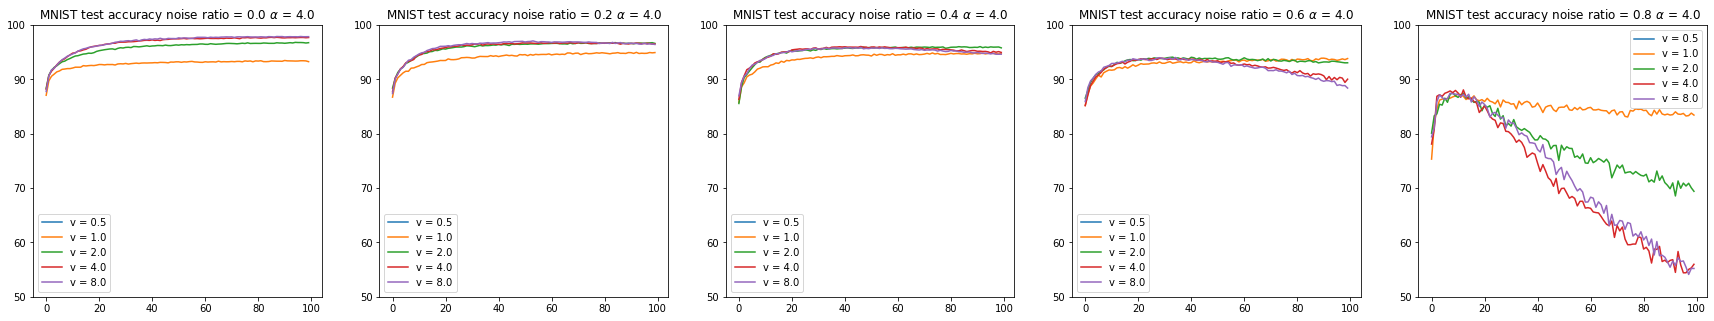

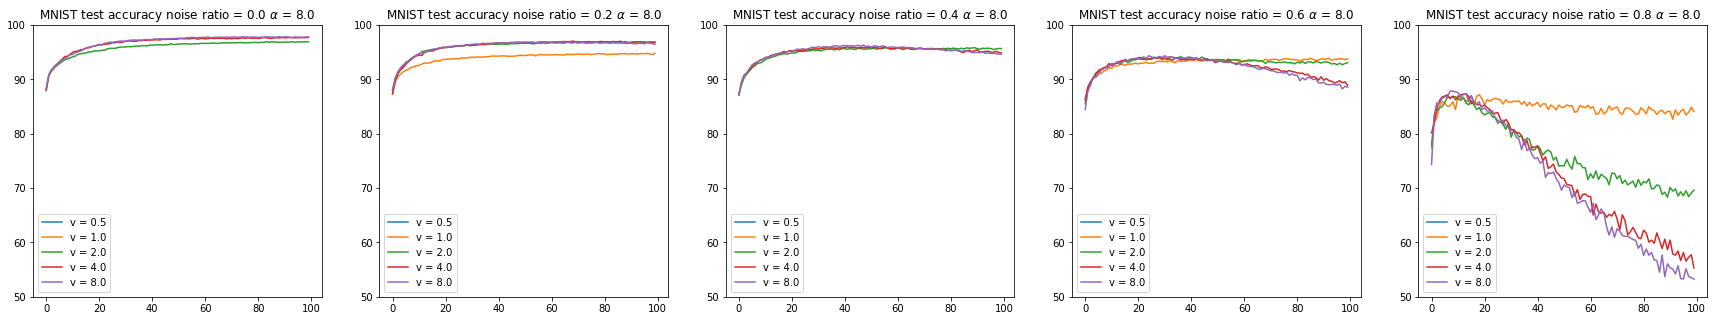

In [142]:
nr_list = list(sdf_mnist2['noise_ratio'].unique())
alpha_list = list(sdf_mnist2['alpha'].unique())
print(alpha_list)
for alpha in alpha_list:
    fig, ax = plt.subplots(1, len(nr_list), figsize=(30, 5))
    for i, nr in enumerate(nr_list):
        plot_along_epoch(case_dict_mnist2,
                         col_of_interests=['test_acc'],
                         key_var='v',
                         key_var_name='v',
                         key_var_filter=lambda x: x>=-1 and x<=8,
                         case_meta_filter=lambda x: (x['noise_ratio'] == nr and x['alpha'] == alpha), ax=ax[i])
        ax[i].set_title(r'MNIST test accuracy noise ratio = {} $\alpha$ = {}'.format(nr, alpha))
        ax[i].set_ylim([50, 100])
    fig.show()

In [21]:
case_dict_mnist3 = extract_log("MNIST", "DNN", "clarify_v_alpha")
sdf_mnist3 = get_stats_df(case_dict_mnist3)
sdf_mnist3

file bk skiped


,key,dataset,model,task_id,cuda,eps,lr,v,batch_size,num_epochs,noise_ratio,alpha,auto
0,MNISTclarify_v_alphaDNN200107001241622,MNIST,DNN,clarify_v_alpha,1,1.9,0.0001,0.5,128,100,0.0,-1.0,True
1,MNISTclarify_v_alphaDNN2001070012423445,MNIST,DNN,clarify_v_alpha,2,1.9,0.0001,1.0,128,100,0.0,-1.0,True
2,MNISTclarify_v_alphaDNN2001070012458229,MNIST,DNN,clarify_v_alpha,3,1.9,0.0001,2.0,128,100,0.0,-1.0,True
3,MNISTclarify_v_alphaDNN200107001255929,MNIST,DNN,clarify_v_alpha,4,1.9,0.0001,4.0,128,100,0.0,-1.0,True
4,MNISTclarify_v_alphaDNN2001070013006496,MNIST,DNN,clarify_v_alpha,5,1.9,0.0001,8.0,128,100,0.0,-1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,MNISTclarify_v_alphaDNN2001071751003529,MNIST,DNN,clarify_v_alpha,2,1.9,0.0001,2.0,128,100,0.8,-0.5,True
238,MNISTclarify_v_alphaDNN2001071755323279,MNIST,DNN,clarify_v_alpha,3,1.9,0.0001,0.0,128,100,0.8,1.0,True
239,MNISTclarify_v_alphaDNN2001071805302956,MNIST,DNN,clarify_v_alpha,2,1.9,0.0001,2.0,128,100,0.8,0.0,True
240,MNISTclarify_v_alphaDNN2001071820171271,MNIST,DNN,clarify_v_alpha,2,1.9,0.0001,2.0,128,100,0.8,0.5,True


[0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 8.0]


C:\Users\wangz\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


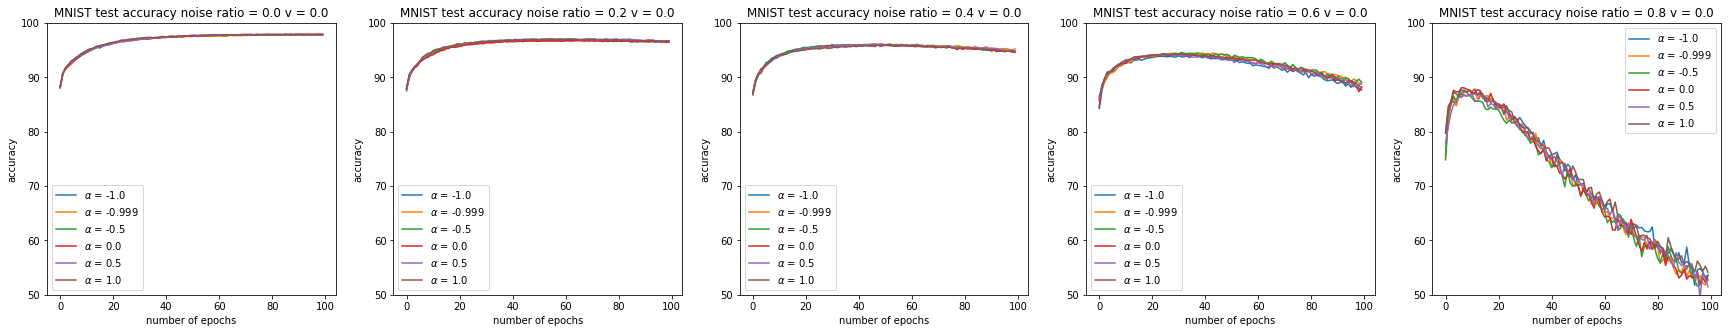

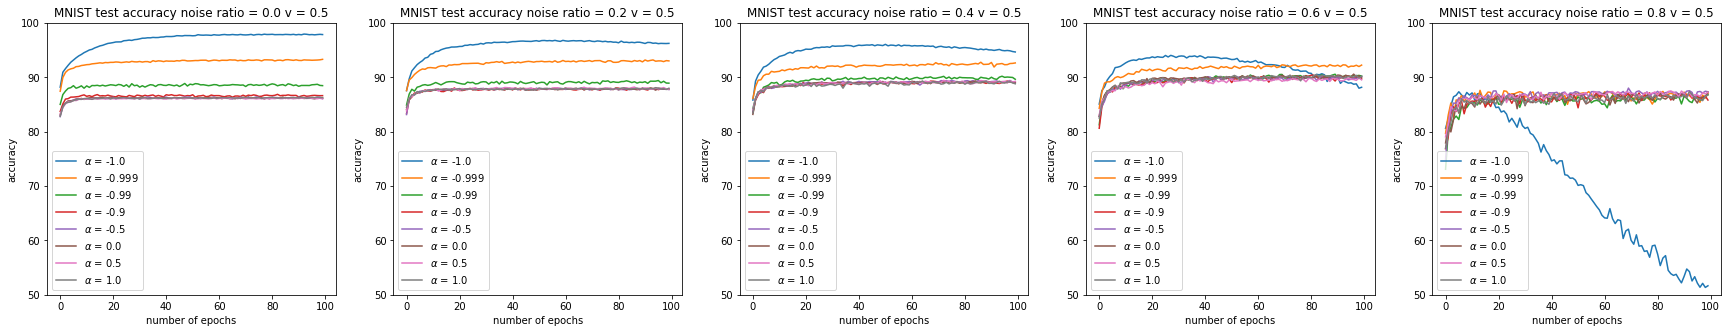

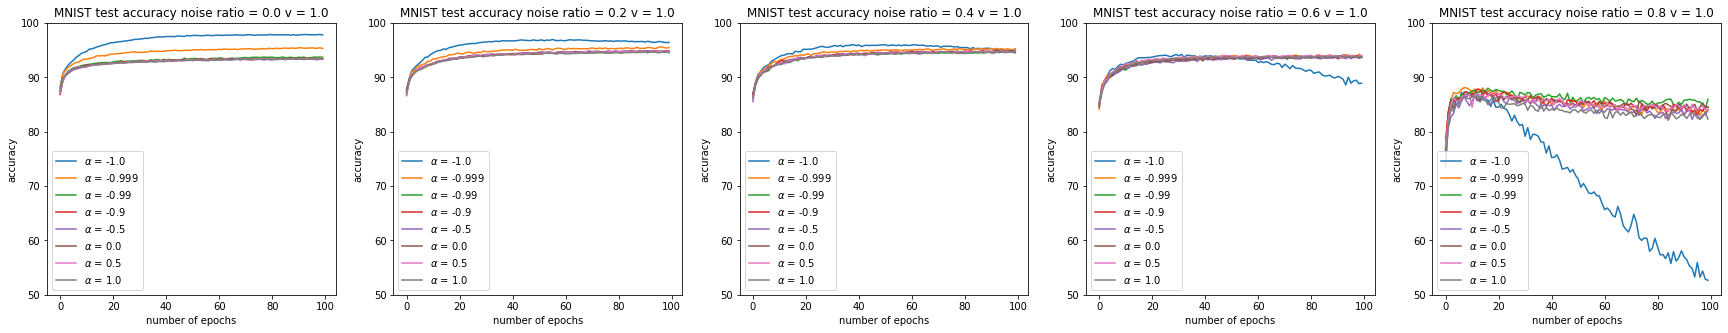

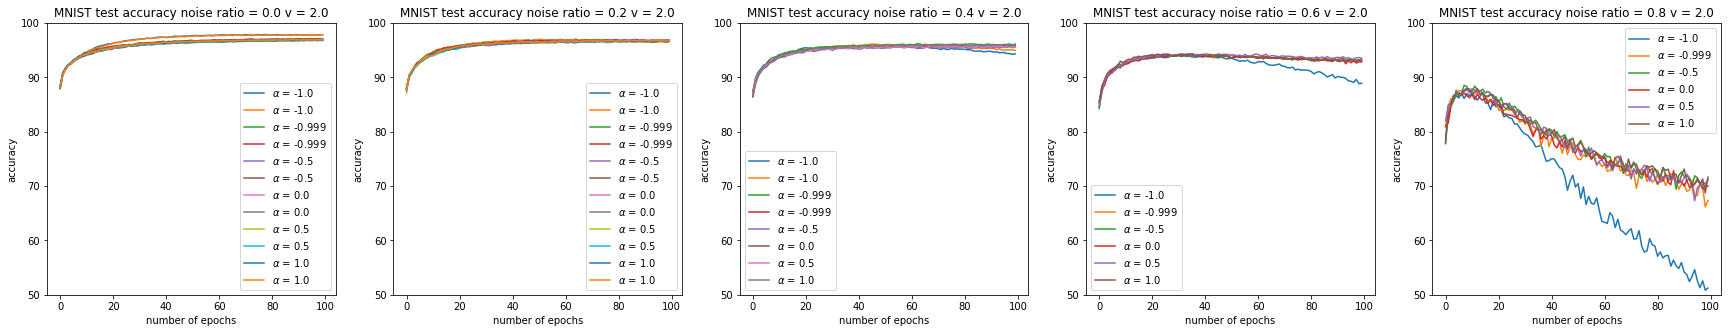

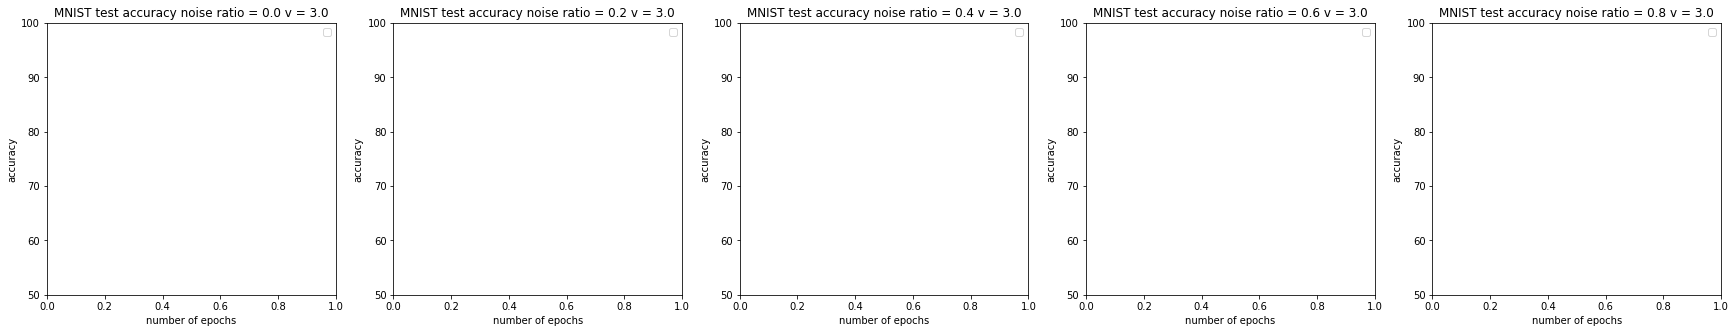

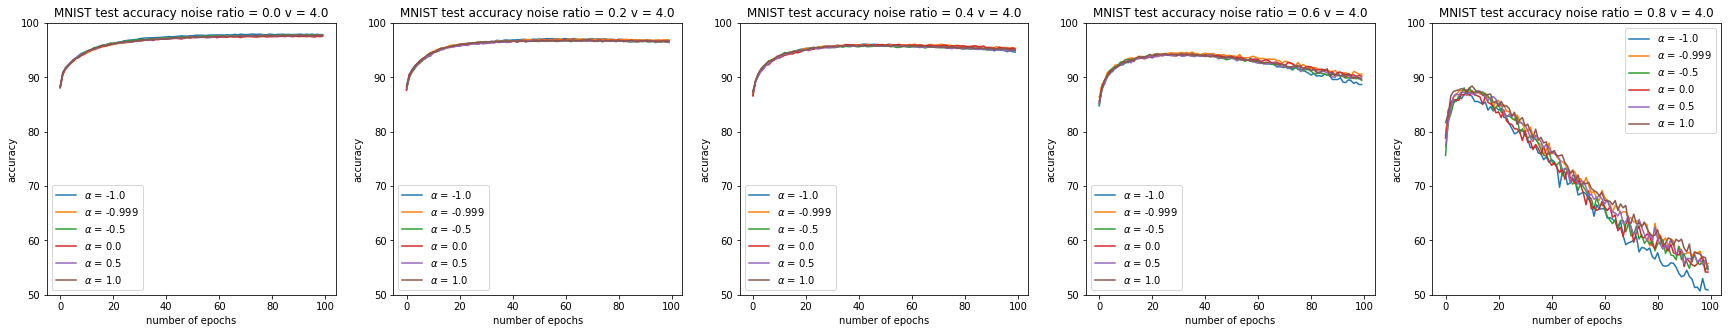

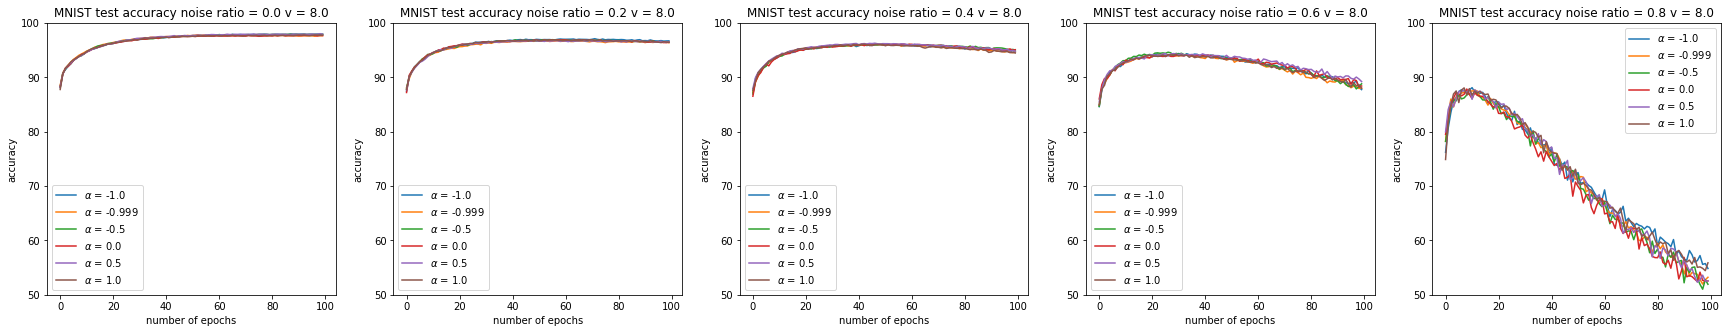

In [30]:

nr_list = list(sdf_mnist3['noise_ratio'].unique())
v_list = sorted(list(sdf_mnist3['v'].unique()))
print(v_list)
for v in v_list:
    fig, ax = plt.subplots(1, len(nr_list), figsize=(30, 5))
    for i, nr in enumerate(nr_list):
        plot_along_epoch(case_dict_mnist3,
                         col_of_interests=['test_acc'], 
                         key_var='alpha',
                         key_var_name=r'$\alpha$',
                         key_var_filter=lambda x: x>=-1 and x<=8,
                         case_meta_filter=lambda x: (x['noise_ratio'] == nr and x['v'] == v), ax=ax[i])
        ax[i].set_title('MNIST test accuracy noise ratio = {} v = {}'.format(nr, v))
        ax[i].set_ylim([50, 100])
        ax[i].set_xlabel('number of epochs')
        ax[i].set_ylabel('accuracy')
    fig.show()


[-1.0, -0.999, -0.99, -0.9, -0.5, 0.0, 0.5, 1.0]


C:\Users\wangz\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


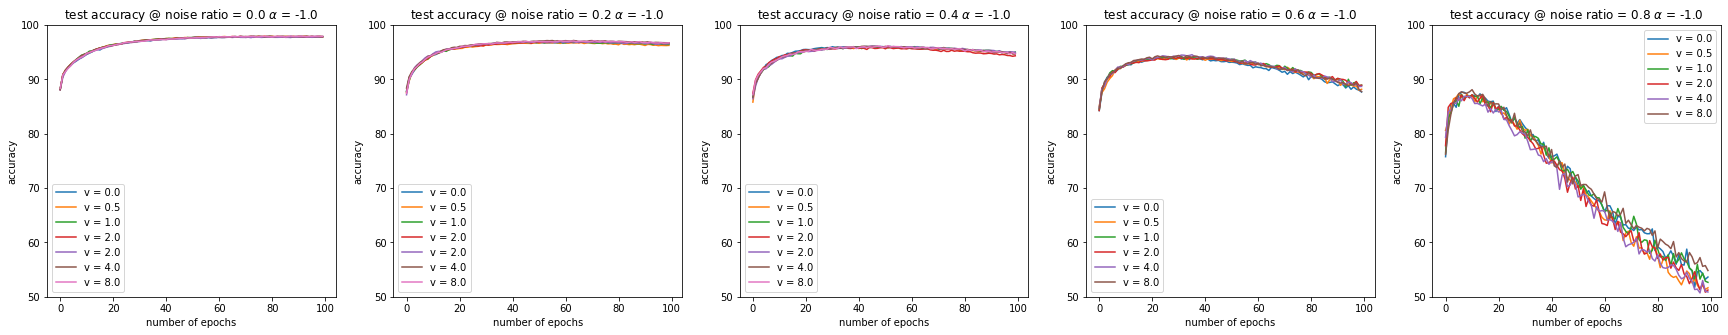

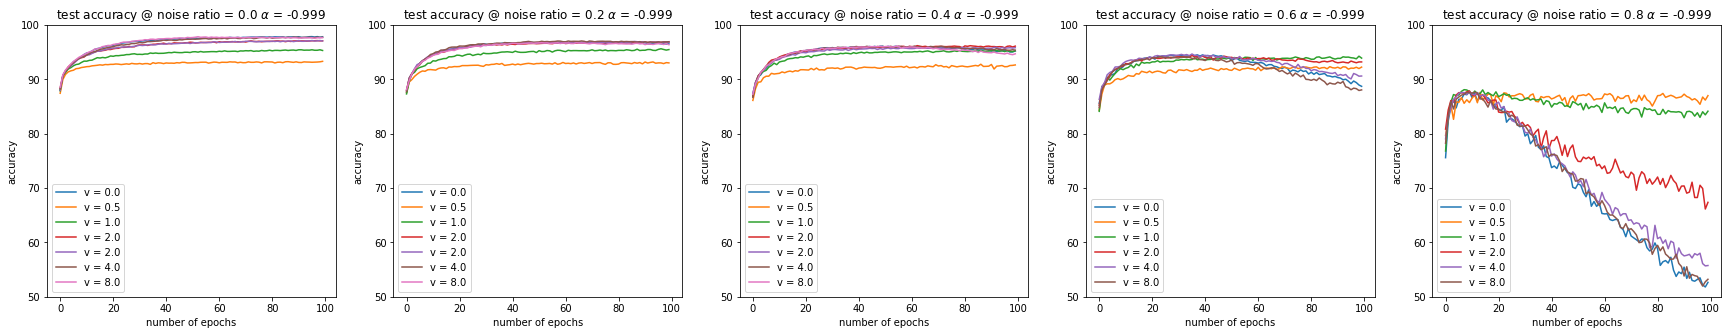

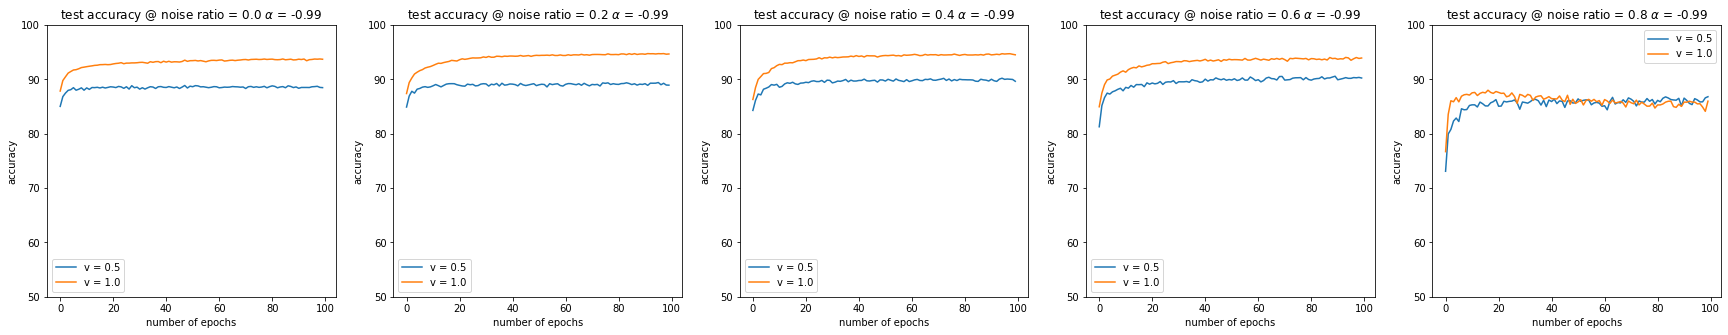

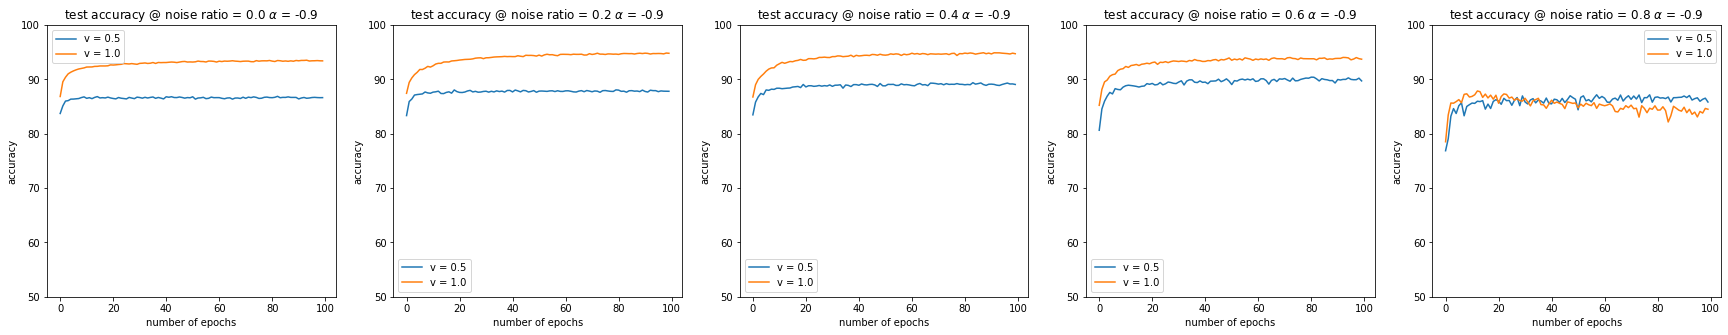

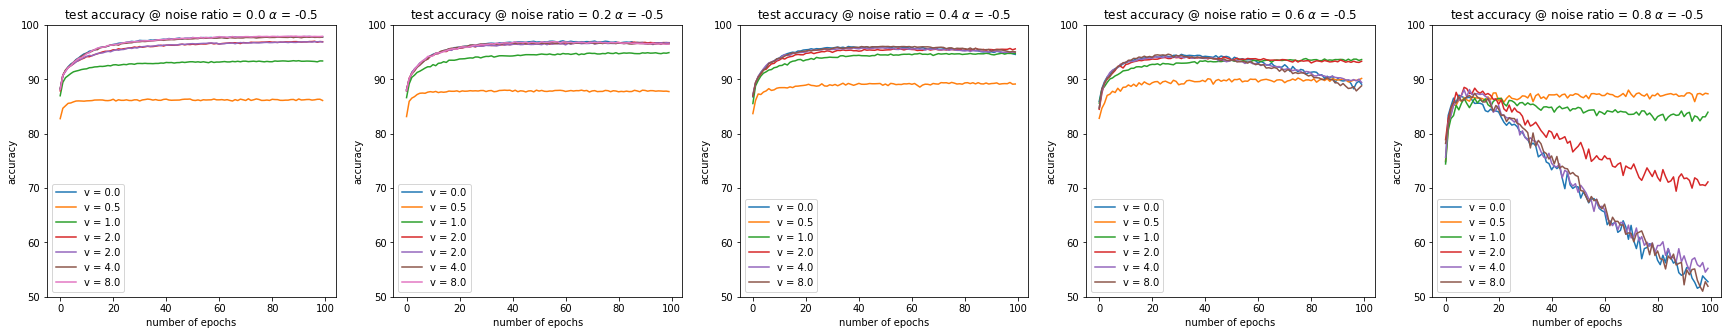

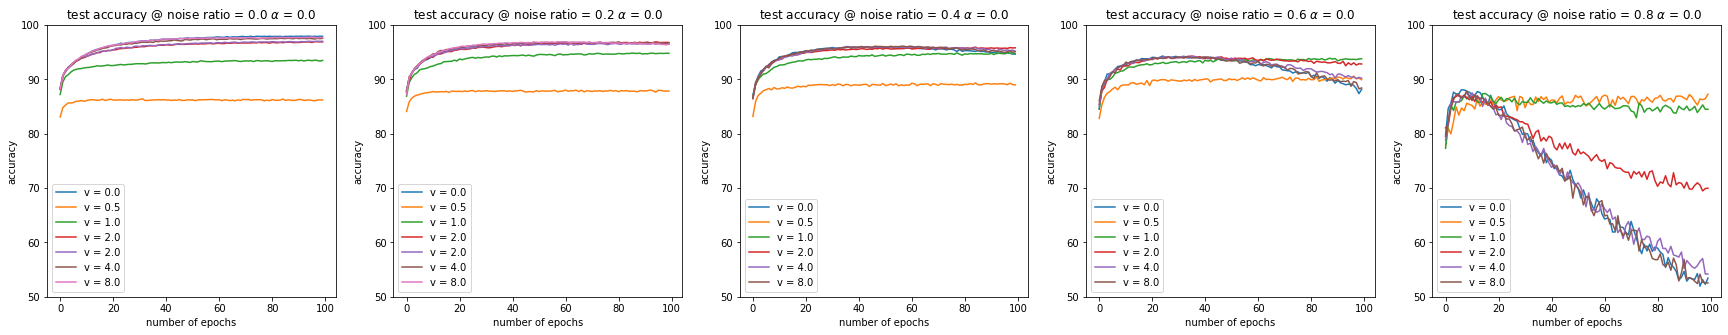

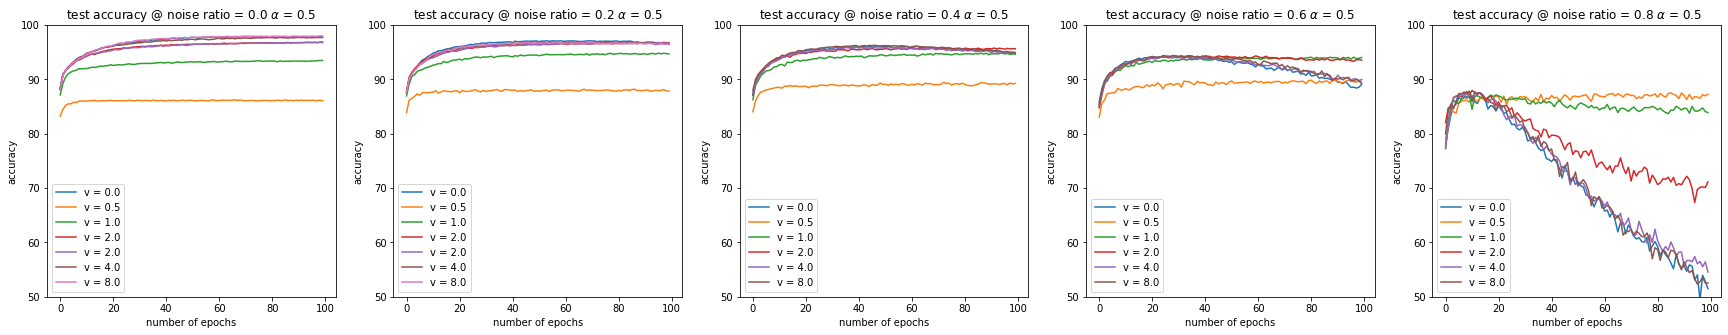

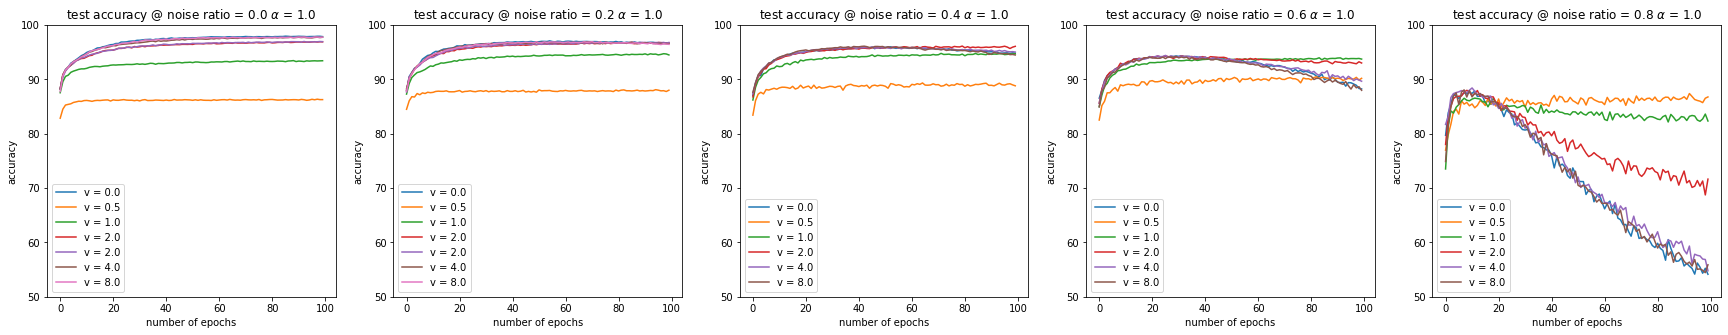

In [31]:
nr_list = list(sdf_mnist3['noise_ratio'].unique())
alpha_list = sorted(list(sdf_mnist3['alpha'].unique()))
print(alpha_list)
for alpha in alpha_list:
    fig, ax = plt.subplots(1, len(nr_list), figsize=(30, 5))
    for i, nr in enumerate(nr_list):
        plot_along_epoch(case_dict_mnist3,
                         col_of_interests=['test_acc'],
                         key_var='v',
                         key_var_name='v',
                         key_var_filter=lambda x: x>=-1 and x<=8,
                         case_meta_filter=lambda x: (x['noise_ratio'] == nr and x['alpha'] == alpha), ax=ax[i])
        ax[i].set_title(r'test accuracy @ noise ratio = {} $\alpha$ = {}'.format(nr, alpha))
        ax[i].set_ylim([50, 100])
        ax[i].set_xlabel('number of epochs')
        ax[i].set_ylabel('accuracy')
    fig.show()

MNISTclarify_v_alphaDNN200107165839416 {'log':     epoch  train_loss  train_acc  val_loss    val_acc  test_loss   test_acc
0       1    2.287473  16.197917  2.279349  17.905031   1.980695  75.593354
1       2    2.272383  18.660417  2.274590  18.486813   1.887598  82.347706
2       3    2.265991  19.110417  2.272092  18.664118   1.849950  84.978244
3       4    2.261249  19.318750  2.270380  19.021498   1.816996  86.333070
4       5    2.256919  19.610417  2.270991  18.741689   1.797733  84.750791
..    ...         ...        ...       ...        ...        ...        ...
95     96    1.947318  32.850000  2.415885  15.112478   1.730675  53.194225
96     97    1.943892  32.858333  2.416623  15.104167   1.720311  53.490902
97     98    1.941166  33.156250  2.420686  15.004433   1.728591  52.185522
98     99    1.937906  33.089583  2.422280  15.176197   1.732521  51.809731
99    100    1.934702  33.237500  2.426969  15.040448   1.721954  52.660206

[100 rows x 7 columns], 'meta': {'datase

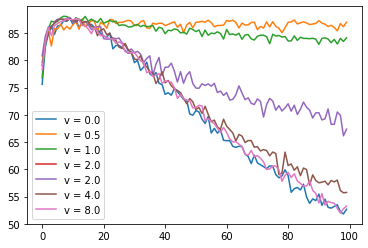

In [28]:
plot_along_epoch(case_dict_mnist3,
                 col_of_interests=['test_acc'],
                 key_var='v',
                 key_var_name='v',
                 key_var_filter=lambda x: x>=-1 and x<=8,
                 case_meta_filter=lambda x: (x['noise_ratio'] == 0.8 and x['alpha'] == -0.999))